# Classificação de Imagens usando Transfer Learning

Neste notebook vamos realizar a classificação de um conjunto de imagens utilizando a técnica de Transfer Learning.

In [ ]:
# Source: https://www.kaggle.com/paultimothymooney/breast-histopathology-images
# https://www.kaggle.com/gpiosenka/inceptionresnetv2-f1-score-86
# https://www.kaggle.com/stpeteishii/breast-histopathology-densenet201
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np
import pandas as pd


Primeiramente, vamos verificar se existe uma GPU em uso:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
tf.test.is_gpu_available() # True/False

2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

A saída esperada é True! 

Agora vamos verificar qual GPU está alocada:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Sep 17 15:56:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    220MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

Vamos baixar o dataset "Breast Histopathology Images" que contém 277.524 imagens referentes a exames. Cada imagem é anotada com um rótulo binário indicando a classe c, onde 0 é negativo e 1 é positivo. Verifique mais informações [neste link](https://www.kaggle.com/paultimothymooney/breast-histopathology-images).

In [ ]:
!pip install -U gdown

In [ ]:
# https://drive.google.com/file/d/1iJGgzBR6-utPvYd1McboHJ11uYqInTWV/view?usp=sharing
!gdown --id 1iJGgzBR6-utPvYd1McboHJ11uYqInTWV

Downloading...
From: https://drive.google.com/uc?id=1iJ5FaDE-RmUpwIaxITwylqbYEa9mh6SX
To: /content/Breast_Cancer.zip
3.33GB [00:53, 62.1MB/s]


In [ ]:
from zipfile import ZipFile

data_dir = 'data'
with ZipFile('Breast_Cancer.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(data_dir)

Esse dataset possui 2 classes.


# Carregando as imagens

In [ ]:
import os
IDS=[]
for ids in os.listdir(data_dir):
    if ids != 'IDC_regular_ps50_idx5':
        IDS+=[ids]
print(len(IDS))

279


In [ ]:
Name=['non-IDC','IDC']
Fname=['0','1']

In [ ]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [ ]:
from tqdm import tqdm
dataset=[]
dataname=[]
for ids in tqdm(os.listdir(data_dir)):
    if ids != 'IDC_regular_ps50_idx5':
        path0=os.path.join(data_dir,ids)
        count=0
        for zero in os.listdir(path0):
            path=os.path.join(path0,zero)
            for im in os.listdir(path):
                image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(32,32))
                image=img_to_array(image)
                image=image/255.0
                dataset+=[image]
                dataname+=[count]
            count=count+1

100%|██████████| 280/280 [03:05<00:00,  1.51it/s]


In [ ]:
n=len(dataset)
print(n)

277524


In [ ]:
data=np.array(dataset)
dataname=np.array(dataname)

In [ ]:
pd.Series(dataname).value_counts()

1    198738
0     78786
dtype: int64

In [ ]:
import random
numb=random.sample(range(n),k=n//10)
m=len(numb)

In [ ]:
train=data[numb[0:(m//10)*8]]
labels0=dataname[numb[0:(m//10)*8]]

test=data[numb[(m//10)*8:]]
tlabels0=dataname[numb[(m//10)*8:]]

In [ ]:
from tensorflow.keras.utils import to_categorical
labels1=to_categorical(labels0)
labels=np.array(labels1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train,labels,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(17760, 32, 32, 3)
(4440, 32, 32, 3)
(17760, 2)
(4440, 2)


# Ploting Images

Vamos ver alguns exemplos das imagens.

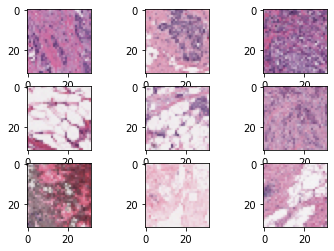

In [ ]:
# plot photos from the Breast Cancer dataset
from matplotlib import pyplot
from matplotlib.image import imread

for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # define filename
  ##filename = os.path.join(nomal_filepath, normal_filename[i])
  # load image pixels
  ##image = imread(filename)
  # plot raw pixel data
  pyplot.imshow(X_train[i])
# show the figure
pyplot.show()

# Generators

Vamos criar os generators, que são responsáveis por carregar as imagens na memória e realizar quaisquer transformações necessárias. Verifique a documentação oficial [neste link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Fonte: https://www.kaggle.com/stpeteishii/breast-histopathology-densenet201

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.1,
                             fill_mode="nearest")

# Download ResNet Model

Vamos baixar o modelo VGG19 treinado no dataset ImageNet. Outros modelos podem ser observados [neste link](https://keras.io/api/applications/).

In [ ]:
# https://keras.io/api/applications/densenet

densenet_model = tf.keras.applications.DenseNet201(
                                          input_shape=(32,32,3),
                                          include_top=False,
                                          weights='imagenet',
                                          pooling='avg')
densenet_model.trainable = False

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
densenet_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

# Método de Transfer Learning

Vamos utilizar o método de transfer learning para adaptar o modelo baixado para nossa tarefa de classificação.

In [ ]:
inputs_model = densenet_model.input
x = tf.keras.layers.Dense(128, activation='relu')(densenet_model.output)
outputs_model = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs_model, outputs=outputs_model)

Agora, vamos mudar nosso novo modelo sequencial, configurando cada camada como "non-trainable". Dessa forma, os pesos dessas camadas não serão atualizados durante o processo de treinamento do modelo.

In [ ]:
for layer in model.layers:
    layer.trainable = False

Por fim, vamos deixar algumas camadas como treináveis.

In [ ]:
for layer in model.layers[-10:]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam 
opt = Adam(learning_rate=0.01)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Training

Agora, vamos iniciar o treinamento do nosso modelo. Lembre-se que, da forma como configuramos as camadas, apenas a última camada será treinada.

In [ ]:
#Defining the parameters
epochs=30

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=1024), validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/30
18/18 [==============================] - 59s 1s/step - loss: 1.7526 - accuracy: 0.6110 - val_loss: 1.6549 - val_accuracy: 0.7088
Epoch 2/30
18/18 [==============================] - 13s 743ms/step - loss: 0.5205 - accuracy: 0.7153 - val_loss: 2.3843 - val_accuracy: 0.7088
Epoch 3/30
18/18 [==============================] - 13s 736ms/step - loss: 0.4562 - accuracy: 0.7153 - val_loss: 0.9456 - val_accuracy: 0.7088
Epoch 4/30
18/18 [==============================] - 14s 813ms/step - loss: 0.4299 - accuracy: 0.7671 - val_loss: 0.6300 - val_accuracy: 0.7475
Epoch 5/30
18/18 [==============================] - 15s 815ms/step - loss: 0.4116 - accuracy: 0.8324 - val_loss: 0.6908 - val_accuracy: 0.7419
Epoch 6/30
18/18 [==============================] - 13s 749ms/step - loss: 0.4002 - accuracy: 0.8330 - val_loss: 0.4688 - val_accuracy: 0.8101
Epoch 7/30
18/18 [==============================] - 13s 768ms/step - loss: 0.3871 - accuracy: 0.8372 - val_loss: 0.5204 - val_accuracy: 0.7721
Ep

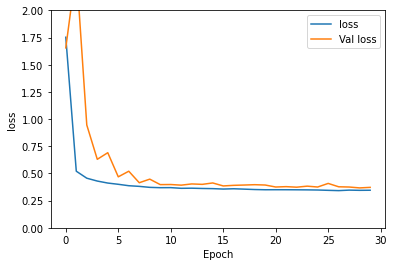

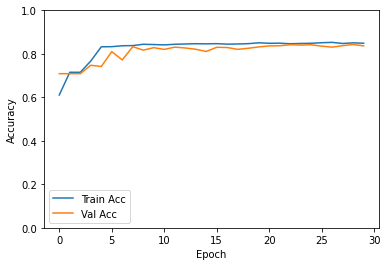

In [ ]:
from matplotlib import pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,2])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Acc')
    plt.ylim([0,1])
    plt.legend()
    plt.show()


plot_history(history)


# Salvando o Modelo

Você pode salvar um modelo inteiro em um único. Para isso, execute o comando a seguir. Para mais informações, verifique [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
model.save('save_model/densenet_breast_cancer_model.h5')


Para baixar o modelo para seu computador, execute o próximo comando.

In [ ]:
from google.colab import files
files.download('save_model/densenet_breast_cancer_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Salvar e baixar todo o modelo pode demorar um pouco. Talvez a melhor opção seja salvar apenas os pesos.

In [ ]:
model.save_weights("save_model/densenet_breast_cancer_model_ckpt")


In [ ]:
!ls -lha save_model/

total 76M
drwxr-xr-x 2 root root 4.0K Sep 17 16:15 .
drwxr-xr-x 1 root root 4.0K Sep 17 16:15 ..
-rw-r--r-- 1 root root  123 Sep 17 16:15 checkpoint
-rw-r--r-- 1 root root  76M Sep 17 16:15 densenet_breast_cancer_model_ckpt.data-00000-of-00001
-rw-r--r-- 1 root root  65K Sep 17 16:15 densenet_breast_cancer_model_ckpt.index


In [ ]:
!tar -jcvf save_model_densenet_breast_cancer_model.tar.bz save_model/

save_model/
save_model/densenet_breast_cancer_model_ckpt.data-00000-of-00001
save_model/densenet_breast_cancer_model_ckpt.index
save_model/checkpoint


In [ ]:
from google.colab import files
files.download('save_model_densenet_breast_cancer_model.tar.bz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Carregando o Modelo

In [ ]:
load_status = model.load_weights("save_model/densenet_breast_cancer_model_ckpt")
load_status

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("save_model/densenet_breast_cancer_model.h5")


# Testing

In [ ]:
scores = model.evaluate(X_test, y_test)
print("Accuracy: {}".format(scores[1]))


139/139 [==============================] - 5s 33ms/step - loss: 0.3718 - accuracy: 0.8367
Accuracy: 0.8367117047309875
